# Inverse Probability Weighting and Doubly Robust Estimation

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo

* Inverse Probability Weighting (IPW)
  * Aplicação no Python
* Doubly Robust Estimation
  * Aplicação no Python




**Observações:** O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer *feedback* ou sugestão de melhoria.

---

### Inverse Probability Weighting

***Intuição***

O Inverse Probability Weighting (IPW) é uma técnica de ponderação por probabilidades inversas. A ideia central é reponderar cada unidade amostral de acordo com o inverso da probabilidade de estar no grupo em que ela efetivamente foi observada.

Esse procedimento cria uma população ponderada (ou pseudo-população) na qual a atribuição do tratamento é independente das covariáveis observadas $X$. Em outras palavras, após a reponderação, os grupos tratados e não tratados tornam-se comparáveis, como se tivessem sido alocados aleatoriamente.

Na literatura também é comum encontrarmos o termo ***Inverse Probability of Treatment Weighting - IPTW***. É a mesma coisa que IPW, mas o nome enfatiza que a probabilidade usada é a de receber o tratamento (*treatment*).

Já o ***Propensity Score Weighting - PSW*** é um caso particular de IPW, quando os pesos são construídos a partir do escore de propensão (*propensity score*). Como o ***escore de propensão*** é justamente a probabilidade de tratamento condicional às covariáveis, então o PSW é um subtipo de IPTW/IPW.

***Definições***

O **Propensity Score** é definido como a probabilidade condicional de uma unidade receber o tratamento dado o vetor de covariáveis observadas:

$$
p(X_i) = \Pr(D_i = 1 \mid X_i)
$$

onde:  
- $D_i \in \{0, 1\}$ é o indicador de tratamento;  
- $X_i$ é o vetor de covariáveis observadas.  

No IPW, cada unidade é reponderada de acordo com:

$$
w_i =
\begin{cases}
\frac{1}{p(X_i)}, & \text{se } D_i = 1 \\
\frac{1}{1 - p(X_i)}, & \text{se } D_i = 0
\end{cases}
$$

O objetivo é criar uma população *pseudo-randomizada*, em que a distribuição das covariáveis seja balanceada entre tratados e não tratados. Diferentemente do *Propensity Score Matching (PSM)*, que emparelha unidades tratadas e não tratadas com base no escore de propensão, o IPW utiliza ***todos os dados disponíveis***, atribuindo pesos às unidades com base em sua probabilidade condicional de tratamento $p(X_i)$.

Repare que:

* Se a unidade é tratada ($D_i=1$):
  * O peso é $1/p(X_i)$.
  * Se $p(X_i)$ for alto (ex.: 0.9), então $1/p(X_i) \approx 1.11$ → peso pequeno.
  * Se $p(X_i)$ for baixo (ex.: 0.1), então $1/p(X_i) = 10$ → peso grande.
  * Ou seja: tratados improváveis de serem tratados recebem mais peso.

* Se a unidade é não tratada ($D_i=0$):
  * O peso é $1/(1 - p(X_i))$.
  * Se $p(X_i)$ for alto (ex.: 0.9), então $1/(1 - p(X_i)) = 10$ → peso grande.
  * Se $p(X_i)$ for baixo (ex.: 0.1), então $1/(1 - p(X_i)) \approx 1.11$ → peso pequeno.
  * Ou seja: não tratados improváveis de serem não tratados recebem mais peso.

O IPW “corrige” a amostra para que grupos que estavam sub-representados fiquem mais visíveis na pseudo-população.
* Um indivíduo que estava em um grupo quase certo (um tratado com $p(X)\approx 1$ ou um controle com $p(X)\approx 0$) ganha peso baixo, porque ele já era muito esperado estar lá.
* Já um indivíduo que parecia estar “no grupo errado” (um tratado com $p(X)$ baixo ou um controle com $p(X)$ alto) ganha peso alto, porque ele ajuda a corrigir o desbalanceamento da amostra.

Esse mecanismo faz com que, após a ponderação:
* A distribuição de $X$ entre tratados e controles fique semelhante.
* A amostra ponderada represente uma situação como se o tratamento tivesse sido atribuído aleatoriamente.

Vamos relembrar o problema de identificação numa representação DAG.

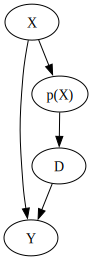

In [71]:
# Importando o pacote
import graphviz as gr

# Gráfico indicando as variáveis e suas relações
g = gr.Digraph()
g.edge("D", "Y")
g.edge("p(X)", "D")
g.edge("X", "Y")
g.edge("X", "p(X)")
g

Em dados observacionais, o tratamento não é aleatório.

Por exemplo: indivíduos com alto nível de escolaridade podem ter alta probabilidade de adotar um tratamento (vacina, tecnologia etc.).

Se compararmos diretamente tratados vs. não tratados, podemos confundir efeito do tratamento com efeito de características $X$ (viés de seleção).

O IPW cria uma pseudo-população em que a probabilidade de tratamento é a mesma para todas as unidades (como se fosse sorteio).

Para isso, ele reequilibra os grupos dando mais peso às observações improváveis:
* Tratados improváveis (baixa chance de ter sido tratados) são valiosos, porque são raros exemplos de tratados em regiões onde normalmente só há controles.
* Controles improváveis (baixa chance de ter sido controles) são valiosos, porque são raros exemplos de controles em regiões onde normalmente só há tratados.


Essas observações “improváveis” são justamente as que ajudam a garantir sobreposição:

* Imagine que em certo nível de $X$ quase todos são tratados.
  * Se aparece um controle improvável ali, ele ajuda a mostrar “como seria o resultado sem tratamento” nesse mesmo nível de $X$.
* Imagine que em outro nível de $X$ quase todos são controles.
  * Se aparece um tratado improvável ali, ele ajuda a mostrar “como seria o resultado com tratamento” nesse mesmo nível de $X$.

### Hipóteses de Identificação


1. **Ignorabilidade (ou não confusão)**:  
   $$
   (Y_i(1), Y_i(0)) \perp D_i \mid p(X_i)
   $$  
   Isto é, não existem confundidores não observados dados $X_i$ (ou uma função de $X_i$).


2. **Sobreposição (ou suporte comum)**:  
   $$
   0 < p(X_i) < 1 \quad \forall i
   $$  
   Cada unidade tem probabilidade positiva de receber ambos os estados de tratamento.


Agora vamos definir os pesos para os diferentes efeitos de tratamento que queremos estimar.

* ATE (Average Treatment Effect)
* ATT (Average Treatment Effect on the Treated)
* ATU (Average Treatment Effect on the Untreated)

***Matematicamente (Horvitz–Thompson - HT - não normalizadas):***

O peso **IPTW para o ATE** é definido como:

$$
w_i^{ATE} = \frac{D_i}{p(X_i)} + \frac{1 - D_i}{1 - p(X_i)}
$$

- Tratados ($D_i = 1$) recebem peso $1 / p(X_i)$  
- Não-Tratados ($D_i = 0$) recebem peso $1 / (1 - p(X_i))$

O peso **IPTW para o ATT** é definido como:

$$
w_i^{ATT} = D_i + (1 - D_i) \cdot \frac{p(X_i)}{1 - p(X_i)}
$$

- Tratados ($D_i = 1$) recebem peso = 1  
- Não-Tratados ($D_i = 0$) recebem peso $p(X_i) / (1 - p(X_i))$


O peso **IPTW para o ATU** é definido como:

$$
w_i^{ATU} = (1 - D_i) + D_i \cdot \frac{1 - p(X_i)}{p(X_i)}
$$

- Tratados ($D_i = 1$) recebem peso $1 - p(X_i) / p(X_i)$
- Não-Tratados ($D_i = 0$) recebem peso = 1


***Interpretação dos pesos***

- **No ATE**:  
  - Unidades tratadas com baixa probabilidade de tratamento recebem peso alto.  
  - Unidades não tratadas com baixa probabilidade de não tratamento recebem peso alto.  

- **No ATT**:  
  - Tratados sempre têm peso 1.  
  - Não tratadas são reponderados para se assemelhar à distribuição de covariáveis dos tratados.

- **No ATU**:  
  - Tratados são reponderados para se assemelhar à distribuição de covariáveis dos não tratados.
  - Não-tratados sempre têm peso 1.

### Aplicação em Python

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

In [85]:
# DataFrame
df = pd.read_stata("https://github.com/Daniel-Uhr/data/raw/main/cattaneo2.dta")

In [86]:
# Criar a variável de resultado
df['Y'] = df['bweight']

# Crie a variável 'Treated' com valor inicial de 0
df['Treated'] = 0
# Recodifique 'Treated' para 1 se 'mbsmoke' for igual a 'smoker'
df.loc[df['mbsmoke'] == 'smoker', 'Treated'] = 1

df['casada'] = 0
df.loc[df['mmarried']=='married', 'casada'] = 1

# gerar uma variável de contagem de linhas iniciando em 1
df['id'] = np.arange(len(df)) + 1

# Conjunto de Covariáveis X
X = ['casada', 'mage', 'medu']

Rodar o escore de propensão e salvar no dataframe "pscore":

In [169]:
# Estimar o escore de propensão com regressão logística
df['pscore'] = smf.logit("Treated ~ casada + mage + medu + fage + fedu + nprenatal", data=df).fit().predict()

Optimization terminated successfully.
         Current function value: 0.444219
         Iterations 6


In [170]:
df[['Y', 'Treated', 'pscore']]

,Y,Treated,pscore
0,3459,0,0.099858
1,3260,0,0.458399
2,3572,0,0.206358
3,2948,0,0.145825
4,2410,0,0.117996
...,...,...,...
4637,3317,1,0.280531
4638,3030,1,0.150491
4639,2950,0,0.255109
4640,3969,0,0.133592


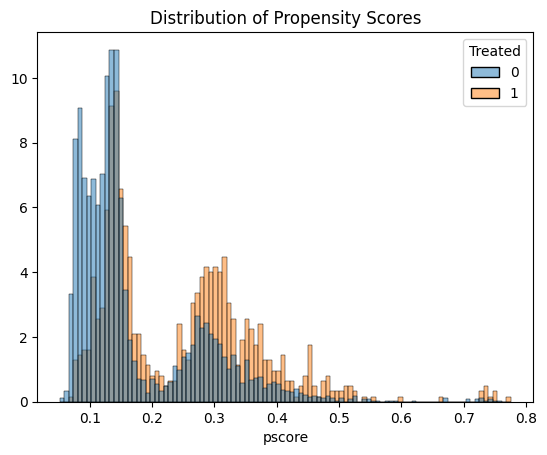

In [171]:
# Verificar graficamente a área de sobreposição
sns.histplot(data=df, x='pscore', hue='Treated', bins=100, stat='density', common_norm=False).\
    set(ylabel="", title="Distribution of Propensity Scores");

Criar os pesos ATE:

In [172]:
# ATE weights
df['W_ATE_T'] = df['Treated'] / df['pscore']
df['W_ATE_C'] = (1 - df['Treated']) / (1 - df['pscore'])

In [173]:
df[['Y', 'Treated', 'pscore', 'W_ATE_T', 'W_ATE_C']]

,Y,Treated,pscore,W_ATE_T,W_ATE_C
0,3459,0,0.099858,0.000000,1.110936
1,3260,0,0.458399,0.000000,1.846377
2,3572,0,0.206358,0.000000,1.260014
3,2948,0,0.145825,0.000000,1.170720
4,2410,0,0.117996,0.000000,1.133782
...,...,...,...,...,...
4637,3317,1,0.280531,3.564674,0.000000
4638,3030,1,0.150491,6.644932,0.000000
4639,2950,0,0.255109,0.000000,1.342478
4640,3969,0,0.133592,0.000000,1.154191


In [174]:
df['Y_psw_ATE'] = df['Y'] * df['W_ATE_T'] - df['Y'] * df['W_ATE_C']

In [175]:
df[['Y', 'Treated', 'pscore', 'W_ATE_T', 'W_ATE_C', 'Y_psw_ATE']]

,Y,Treated,pscore,W_ATE_T,W_ATE_C,Y_psw_ATE
0,3459,0,0.099858,0.000000,1.110936,-3842.727703
1,3260,0,0.458399,0.000000,1.846377,-6019.189806
2,3572,0,0.206358,0.000000,1.260014,-4500.770983
3,2948,0,0.145825,0.000000,1.170720,-3451.282124
4,2410,0,0.117996,0.000000,1.133782,-2732.414892
...,...,...,...,...,...,...
4637,3317,1,0.280531,3.564674,0.000000,11824.022325
4638,3030,1,0.150491,6.644932,0.000000,20134.144440
4639,2950,0,0.255109,0.000000,1.342478,-3960.311042
4640,3969,0,0.133592,0.000000,1.154191,-4580.984566


In [176]:
df['Y_psw_ATE'].mean()

***ATT psw***

In [177]:
# ATT weights
df['W_ATT_T'] = df['Treated'] * 1 
df['W_ATT_C'] = (1 - df['Treated']) * (df['pscore'] / (1 - df['pscore']))

In [178]:
df[['Y', 'Treated', 'pscore', 'W_ATT_T', 'W_ATT_C']]

,Y,Treated,pscore,W_ATT_T,W_ATT_C
0,3459,0,0.099858,0,0.110936
1,3260,0,0.458399,0,0.846377
2,3572,0,0.206358,0,0.260014
3,2948,0,0.145825,0,0.170720
4,2410,0,0.117996,0,0.133782
...,...,...,...,...,...
4637,3317,1,0.280531,1,0.000000
4638,3030,1,0.150491,1,0.000000
4639,2950,0,0.255109,0,0.342478
4640,3969,0,0.133592,0,0.154191


In [179]:
df['Y_psw_ATT'] = df['Y'] * df['W_ATT_T'] - df['Y'] * df['W_ATT_C']

In [180]:
df['Y_psw_ATT'].mean()

***ATU psw***

In [181]:
# ATU weights
df['W_ATU_T'] = df['Treated'] * (1 - df['pscore']) / df['pscore']
df['W_ATU_C'] = (1 - df['Treated']) * 1

In [182]:
df[['Y', 'Treated', 'pscore', 'W_ATU_T', 'W_ATU_C']]

,Y,Treated,pscore,W_ATU_T,W_ATU_C
0,3459,0,0.099858,0.000000,1
1,3260,0,0.458399,0.000000,1
2,3572,0,0.206358,0.000000,1
3,2948,0,0.145825,0.000000,1
4,2410,0,0.117996,0.000000,1
...,...,...,...,...,...
4637,3317,1,0.280531,2.564674,0
4638,3030,1,0.150491,5.644932,0
4639,2950,0,0.255109,0.000000,1
4640,3969,0,0.133592,0.000000,1


In [183]:
df['Y_psw_ATU'] = df['Y'] * df['W_ATU_T'] - df['Y'] * df['W_ATU_C']

In [184]:
df['Y_psw_ATU'].mean()

**IPW Normalizado**

É comum utilizar a normalização dos pesos de IPW para garantir que a soma dos pesos seja igual a 1. Isso é feito dividindo cada peso pela soma total dos pesos. Isso também ajuda a reduzir a variância dos estimadores ponderados. É conhecido como a forma de Hájek para o PSW.

In [185]:
df['Y_psw_ATE_normalized'] = (df['Y'] * df['W_ATE_T'] / df['W_ATE_T'].sum()) - (df['Y'] * df['W_ATE_C'] / df['W_ATE_C'].sum())

In [186]:
df[['Y', 'Treated', 'pscore', 'Y_psw_ATE_normalized']]

,Y,Treated,pscore,Y_psw_ATE_normalized
0,3459,0,0.099858,-0.823875
1,3260,0,0.458399,-1.290505
2,3572,0,0.206358,-0.964958
3,2948,0,0.145825,-0.739950
4,2410,0,0.117996,-0.585826
...,...,...,...,...
4637,3317,1,0.280531,2.661741
4638,3030,1,0.150491,4.532458
4639,2950,0,0.255109,-0.849085
4640,3969,0,0.133592,-0.982156


Para recuperar o efeito quando utilizamos os pesos normalizados somamos as contribuições individuais.

In [187]:
df['Y_psw_ATE_normalized'].sum()

***ATT normalizado***

In [188]:
df['Y_psw_ATT_normalized'] = (df['Y'] * df['W_ATT_T'] / df['W_ATT_T'].sum()) - (df['Y'] * df['W_ATT_C'] / df['W_ATT_C'].sum())

In [189]:
df['Y_psw_ATT_normalized'].sum()

***ATU normalizado***


In [191]:
df['Y_psw_ATU_normalized'] = (df['Y'] * df['W_ATU_T'] / df['W_ATU_T'].sum()) - (df['Y'] * df['W_ATU_C'] / df['W_ATU_C'].sum())

In [192]:
df['Y_psw_ATU_normalized'].sum()

Repare que os resultados são diferentes mesmo possuindo o mesmo alvo (ATE, ATT, ATU). Isso ocorre, porque:

* Horvitz–Thompson (HT) é não-normalizado, pode ter mais variância, mas é não-viesado sob overlap.
* Hájek é normalizado, tende a ser mais estável em amostras finitas, mas pode ter um viés pequeno.

Por isso o número pode mudar bastante — principalmente se você tiver pesos extremos (como você já viu: alguns > 10). O Hájek “reescala” as contribuições, o que pode puxar o efeito para outro valor.

### Aplicando no Python

Para realizar a aplicação direta da ponderação por IPW, com efeito médio do tratamento e seus intervalos de confiança, podemos utilizar a biblioteca `statsmodels` para ajustar um modelo de regressão ponderada.


Aqui calculamos os pesos para os indivíduos tratados e não tratados em uma variável no dataframe.

In [193]:
# ATE weights no python
df['W_ATE_ols'] = df['Treated'] / df['pscore'] + (1 - df['Treated']) / (1 - df['pscore'])

Depois rodamos a regressão para encontrar o ATE:

In [194]:
# Aplicando regressão ponderada (IPTW) para ATE
model_ate = smf.wls("Y ~ Treated", data=df, weights=df['W_ATE_ols']).fit()
print(model_ate.summary())

                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.038
Model:                            WLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     183.3
Date:                qui, 21 ago 2025   Prob (F-statistic):           5.38e-41
Time:                        15:28:07   Log-Likelihood:                -36579.
No. Observations:                4642   AIC:                         7.316e+04
Df Residuals:                    4640   BIC:                         7.318e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3399.2003     11.701    290.515      0.0

Repare que uma propriedade importante do WLS (Weighted Least Squares), é que ele já faz a normalização implícita (ele força as médias ponderadas a se alinharem com os pesos), mesmo que nós tenhamos indicado pesos diferentes.

Para o ATT:

In [195]:
# ATT weights
df['W_ATT_ols'] = df['Treated'] * 1  + (1 - df['Treated']) * (df['pscore'] / (1 - df['pscore']))

In [196]:
# Aplicando regressão ponderada (IPTW) para ATT
model_att = smf.wls("Y ~ Treated", data=df, weights=df['W_ATT_ols']).fit()
print(model_att.summary())

                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.029
Model:                            WLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     140.1
Date:                qui, 21 ago 2025   Prob (F-statistic):           7.15e-32
Time:                        15:28:13   Log-Likelihood:                -37105.
No. Observations:                4642   AIC:                         7.421e+04
Df Residuals:                    4640   BIC:                         7.423e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3340.7478     12.054    277.146      0.0

ATT com peso IPTW normalizado é -213.3092

Para o ATU

In [197]:
df['W_ATU_ols'] = df['Treated'] * (1 - df['pscore']) / df['pscore'] + (1 - df['Treated']) * 1

In [198]:
# Aplicando regressão ponderada (IPTW) para ATU
model_atu = smf.wls("Y ~ Treated", data=df, weights=df['W_ATU_ols']).fit()
print(model_atu.summary())

                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.040
Model:                            WLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     194.7
Date:                qui, 21 ago 2025   Prob (F-statistic):           2.21e-43
Time:                        15:28:18   Log-Likelihood:                -36556.
No. Observations:                4642   AIC:                         7.312e+04
Df Residuals:                    4640   BIC:                         7.313e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3412.9116     11.604    294.121      0.0

## Doubly Robust Estimation (DR - AIPW)

***Doubly Robust Estimation (DR)***

* É a ideia geral de combinar Outcome Regression e Inverse Probability Weighting. 
* Um estimador é “duplamente robusto” quando é consistente se pelo menos um dos modelos (de resultado ou de propensão) estiver corretamente especificado. 
  * Exemplo clássico: *Augmented Inverse Probability Weighting - AIPW*.


***AIPW (Augmented Inverse Probability Weighting)***

Na avaliação de efeitos causais, dois métodos são comuns:  

- **Outcome Regression (OR):** modelar diretamente o resultado condicional a $X$ e $D$.  
- **Inverse Probability Weighting (IPW):** reponderar as observações pelo escore de propensão $\hat{p}(X)$.  
- Lembre que cada um dos estimadores é **consistente apenas se o modelo estiver corretamente especificado**.  

O **estimador duplamente robusto (Doubly Robust, ou Augmented IPW - AIPW)** combina as duas abordagens, garantindo consistência se **pelo menos um dos modelos estiver correto**.

**Componentes básicos**

- Tratamento: $D_i \in \{0,1\}$
- Covariáveis: $X_i$
- Resultado: $Y_i = D_i Y_i(1) + (1-D_i) Y_i(0)$
- Propensity score: $p(X) = P(D=1|X)$
- Funções de regressão: $\mu_d(X) = E[Y|D=d,X]$

Queremos o efeito médio do tratamento (ATE):

$$
\beta_{ATE} = E[Y(1) - Y(0)] 
$$


#### Outcome Regression (OR)

O estimador para o ATE é:

$$
\hat{\beta}^{OR}_{ATE} = \frac{1}{n}\sum_{i=1}^n \left[ \hat{\mu}_1(X_i) - \hat{\mu}_0(X_i) \right]
$$

onde $\hat{\mu}_d(X)$ pode ser obtido por regressão (em casos mais sofisticados, pode ser modelado de outras formas).


#### Inverse Probability Weighting (IPW)

O estimador ATE via IPW é:

$$
\hat{\beta}^{IPW}_{ATE} = \frac{1}{n}\sum_{i=1}^n \left( \frac{D_i Y_i}{\hat{p}(X_i)} - \frac{(1-D_i)Y_i}{1-\hat{p}(X_i)} \right)
$$


#### Estimador Doubly Robust (AIPW)

O estimador duplamente robusto para o ATE é dado por:

$$
\hat{\beta}^{DR}_{ATE} = \frac{1}{n}\sum_{i=1}^n \Bigg\{ \Big(\hat{\mu}_1(X_i) - \hat{\mu}_0(X_i)\Big) \;+\; \frac{D_i}{\hat{p}(X_i)}\big(Y_i - \hat{\mu}_1(X_i)\big) \;-\; \frac{1-D_i}{1-\hat{p}(X_i)}\big(Y_i - \hat{\mu}_0(X_i)\big) \Bigg\}
$$

**Interpretação:**  

- O **primeiro termo** ($\hat{\mu}_1 - \hat{\mu}_0$) é a predição média da regressão de resultados (*Outcome Regression*).  
- Os **termos adicionais** são “correções” baseadas em resíduos ponderados por IPW.  


***Propriedade de Dupla Robustez***

- Se $\hat{\mu}_d(X)$ estiver corretamente especificado → os resíduos têm média zero, e o estimador DR converge para o ATE mesmo que $\hat{p}(X)$ esteja errado.  
- Se $\hat{p}(X)$ estiver corretamente especificado → a ponderação corrige vieses da regressão mal especificada, garantindo consistência.  
- Se **ambos** estiverem corretos → o estimador é **eficiente** (atinge menor variância assintótica).


***Em termos intuitivos:***

- O DR é chamado também de **Augmented IPW** porque começa com IPW e **adiciona regressão dos resultados** como “ajuste extra”.  
- Outra visão: é uma **regressão de resultados com resíduos reponderados**, de modo que o viés de especificação de um modelo é compensado pelo outro.  


**Extensões**

- **ATT (Average Treatment Effect on the Treated):** versão análoga existe, com pesos ajustados para focar nos tratados.
- **ATU (Average Treatment Effect on the Untreated):** versão análoga existe, com pesos ajustados para focar nos não tratados.


**Por que a o estimador Duplamente Robusto (*Augmented Inverse Probability Weighting* - AIPW) é tão atraente?**

A razão é que só precisamos de uma das duas previsões, *$\hat{\mu}$* ou *$\hat{p}$*, para que a estimativa seja correta (não enviesada/imparcial). 
* Se ambos os modelos estiverem corretos, o estimador será mais eficiente do que qualquer um dos modelos sozinho. 
* Se um dos modelos estiver errado, o estimador ainda será consistente, desde que o outro modelo esteja correto. 

Isso é uma grande vantagem em relação a outras abordagens, como a regressão de resultados ou a ponderação pelo escore de propensão, que exigem que ambos os modelos estejam corretos para que o estimador seja consistente.

Suponha que $\hat{\mu}$ esteja especificado corretamente. Então $E[\hat{\mu}^{d}(x)=E[Y|X=x, D=d]$ , então o estimador DR é consistente, mesmo que o modelo de propensão $\hat{p}$ esteja mal especificado.

$$ \hat{\beta^{DR}} =  \mathbb{E} \left[ (\mu_1(X) - \mu_0 (X)) +  \frac{D}{\hat{p}(X)}.(Y_{1} - \mu_1 (X)) - \frac{(1-D)}{1-\hat{p}(X)}.(Y_{0} - \mu_0 (X)) \right] = $$

$$  =  \mathbb{E} \left[ (\mu_1(X) - \mu_0 (X)) \right] = $$

$$  =  \mathbb{E} \left[ Y^{1} - Y^{0} \right] = $$

$$ = \beta $$

A intuição é que, se $\hat{\mu}$ está **especificado corretamente é imparcial e o fator de ajuste desaparece**, uma vez que os resíduos convergem para zero.


Por outro lado, suponha $\hat{p}$ está especificado corretamente, ou seja, $E[\hat{p}(X)]=P(D=1|X)$, então o estimador DR é consistente, mesmo que o modelo de resultados $\hat{\mu}$ esteja mal especificado.

$$ \hat{\beta^{DR}} =  \mathbb{E} \left[ (\mu_1(X) - \mu_0 (X)) +  \frac{D}{\hat{p}(X)}.(Y_{1} - \mu_1 (X)) - \frac{(1-D)}{1-\hat{p}(X)}.(Y_{0} - \mu_0 (X)) \right] = $$

$$ \mathbb{E} \left[ \mu_1(X) - \mu_0 (X) + \frac{D}{\hat{p}(X)}.Y_{1} - \frac{D}{\hat{p}(X)}.\mu_1 (X) - \frac{(1-D)}{1-\hat{p}(X)}Y_{0} + \frac{(1-D)}{1-\hat{p}(X)}.\mu_0 (X) \right] = $$


$$ \mathbb{E} \left[ \frac{D}{\hat{p}(X)}.Y_{1} - \frac{(1-D)}{1-\hat{p}(X)}Y_{0} + \mu_1(X) - \frac{D}{\hat{p}(X)}.\mu_1 (X) + \frac{(1-D)}{1-\hat{p}(X)}.\mu_0 (X) - \mu_0 (X) \right] = $$


$$ \mathbb{E} \left[ \frac{D}{\hat{p}(X)}.Y_{1} - \frac{(1-D)}{1-\hat{p}(X)}Y_{0} + \mu_1(X) (1 - \frac{D}{\hat{p}(X)}) + \mu_0 (X)(\frac{(1-D)}{1-\hat{p}(X)} - 1) \right] = $$

$$ \mathbb{E} \left[ \frac{D}{\hat{p}(X)}.Y_{1} - \frac{(1-D)}{1-\hat{p}(X)}Y_{0} + \mu_1(X) (\frac{\hat{p}(X) - D}{\hat{p}(X)}) + \mu_0 (X)(\frac{(1-D)- (1-\hat{p}(X))}{1-\hat{p}(X)}) \right] = $$

$$ \mathbb{E} \left[ \frac{D}{\hat{p}(X)}.Y_{1} - \frac{(1-D)}{1-\hat{p}(X)}Y_{0} \right] = $$

$$ \mathbb{E} \left[ Y^{1} - Y^{0} \right] = $$

$$ = \beta $$

A intuição é que, se $\hat{p}$ está especificado corretamente, o $\hat{\beta}^{DR}$ é não viesado e o fator de ajuste desaparece, uma vez que os resíduos ($D_{i}-\hat{p}(X)$) convergem para zero.


## Aplicação em Python

Para facilitar a aplicação vamos utilizar uma abordagem moderna da biblioteca da Microsoft (EconML) chamada ***DR-Learner***.

Posteriormente vou trabalhar melhor os conceitos de CATE e Meta-Learners, mas por enquanto vamos focar na aplicação prática.


**Estimativa Duplamente Robusta**

Vamos fazer "na mão"

In [216]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [217]:
X_cols = ['casada', 'mage', 'medu', 'fage', 'fedu', 'nprenatal']   

# 1. Estimar propensity score
logit = LogisticRegression()
logit.fit(df[X_cols], df['Treated'])
df['ps'] = logit.predict_proba(df[X_cols])[:,1]

In [218]:
# 2. Estimar outcome regression separada por grupo
reg1 = LinearRegression().fit(df.loc[df.Treated==1, X_cols], df.loc[df.Treated==1, 'Y'])
reg0 = LinearRegression().fit(df.loc[df.Treated==0, X_cols], df.loc[df.Treated==0, 'Y'])

df['mu1'] = reg1.predict(df[X_cols])
df['mu0'] = reg0.predict(df[X_cols])

In [219]:
# 3. Construir o DR-ATE linha a linha
df['DR_ATE'] = (df['mu1'] - df['mu0'] 
                + df['Treated']/df['ps']*(df['Y'] - df['mu1'])
                - (1-df['Treated'])/(1-df['ps'])*(df['Y'] - df['mu0']))

In [220]:
# 4. Estimativa final
tau_dr = df['DR_ATE'].mean()
print("DR-ATE =", tau_dr)

DR-ATE = -225.54573768105288


In [221]:
# DR-ATT
DR_ATT = df['mu1'] - df['mu0'] + df["Treated"] * (df["Y"] - df['mu1']) - (1-df["Treated"])*df['ps'] / (1-df['ps']) * (df["Y"] - df['mu0'])
print("DR-ATT =", np.mean(DR_ATT))

DR-ATT = -228.03205783404923


In [222]:
# DR - ATU
DR_ATU = df['mu1'] - df['mu0'] + (1-df["Treated"]) * (df["Y"] - df['mu0']) - df['ps'] / (1-df['ps']) * (df["Y"] - df['mu1'])
print("DR-ATU =", np.mean(DR_ATU))

DR-ATU = -266.5862436957349


Esse tipo de estimador é bastante importante na literatura. E já possui alguns estimadores que realizam as estimações de forma direta. Por exemplo, poderíamos computar diretamente com 'LinearDRLearner' da biblioteca 'EconML' da Microsoft (EconML - Estimate causal effects with ML).

obs: https://www.microsoft.com/en-us/research/project/econml/

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from econml.dr import DRLearner
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression

In [255]:
X = df[['casada','mage','medu','fage','fedu','nprenatal']].values
Y = df['Y'].values
T = df['Treated'].values

In [ ]:
dr = DRLearner(
    model_propensity=LogisticRegression(),
    model_regression=LinearRegression(),
    model_final=StatsModelsLinearRegression(),
    cv=5,
    random_state=45
)

dr.fit(Y=Y, T=T, X=X)

dr.ate_inference(X).summary().tables[0]

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


mean_point,stderr_mean,zstat,pvalue,ci_mean_lower,ci_mean_upper
-221.665,58.548,-3.786,0.0,-336.418,-106.912


O modelo nos dá diretamente o efeito médio do tratamento (ATE). A estimativa é estatisticamente diferente de zero e o intervalo de confiança inclui o valor verdadeiro que encontramos manualmente. Observe que obtivemos uma estimativa diferente porque a função **LinearDRLearner** também realizou o cross-fitting em segundo plano, o que não fizemos antes.

Outros pacotes importantes são 
* "causalml" (https://causalml.readthedocs.io/en/latest/about.html).
* "DoubleML" (https://doubleml.org/stable/).

## Boas práticas

* Verifique o balanço das covariáveis.
  * Tanto o IPW quanto o DR (AIPW) foram desenvolvidos para ambientes nos quais o tratamento não é atribuído aleatoriamente incondicionalmente, mas pode depender de algumas variáveis observáveis. Essas informações podem ser verificadas de duas maneiras: 
    * (1) Produza uma tabela de médias/equilíbrio das covariáveis. Se a randomização incondicional não for válida, esperamos ver diferenças significativas entre alguns observáveis; 
    * (2) Trace os escores de propensão estimados. Se a randomização incondicional for válida, esperamos que os escores de propensão sejam constantes.
* Verifique a suposição de sobreposição.
  * Podemos simplesmente verificar os limites dos escores de propensão previstos. Se a suposição de sobreposição for violada, acabamos dividindo algum termo do estimador por zero.